In [ ]:
import nltk
import nltk.corpus
nltk.download('punkt')
import pandas as pd
import re
import matplotlib.pyplot as plt
import altair as alt
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
path = '../Data/'

In [ ]:
white = pd.read_csv(path + 'white_reviews.csv', sep=';', encoding='ansi', quotechar='"', names=['url', 'info', 'rate', 'likes', 'comments', 'year', 'lang', 'text'])
red = pd.read_csv(path + 'red_reviews.csv', sep=';', encoding='ansi', quotechar='"', names=['url', 'info', 'rate', 'likes', 'comments', 'year', 'lang', 'text'])
df = pd.concat([white, red])

df['url'] = df.apply(lambda row : row['url'].replace('\r\n', ''), axis=1)

In [ ]:
df['year'] = df['year'].replace(value='', regex='Annata').astype(int)
df['rate'] = df['rate'].replace(value='.', regex=',').astype(float)
df['likes'] = df['likes'].astype(int)
df['comments'] = df['comments'].astype(int)


(array([2.6300e+02, 1.2400e+02, 7.4900e+02, 1.2710e+03, 3.2000e+01,
        8.7330e+03, 2.0471e+04, 6.8461e+04, 4.8621e+04, 2.7848e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

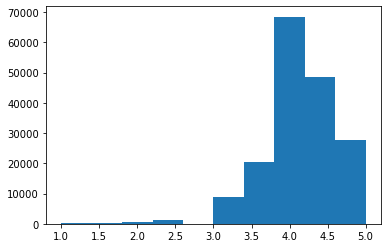

In [ ]:
plt.hist(df.rate)

In [ ]:
df = df[df.lang=='it']

In [ ]:
df['reviewer'] = df['info'].apply(lambda x : x.split(' (')[0])
df['date'] = df['info'].apply(lambda x : x.split('\r\n')[-1])

def clean_n_revs(x):
    if len(x.split(' ('))>1:
        for elem in x.split(' ('):
            if 'Voti)' in elem:
                return int(elem.split(' Voti')[0])
        return 0

df['n_reviews'] = df.apply(lambda row : clean_n_revs(row['info']), axis=1)
df =  df.drop(columns='info')
df = df.dropna()

In [ ]:
df.head()

df = df.drop_duplicates(subset=['text', 'reviewer'], ignore_index=True)

In [ ]:
olfactory = pd.read_csv(path+'olfactory_terms.txt', names=['termini']).termini.to_list()
olfactory = [word.lower() for word in olfactory]
visual =  pd.read_csv(path+'visual_terms.txt', names=['termini']).termini.to_list()
visual = [word.lower() for word in visual]
gustative =  pd.read_csv(path+'gustative_terms.txt', names=['termini']).termini.to_list()
gustative = [word.lower() for word in gustative]


In [ ]:
def count_termini(text, terms):
    counter = 0
    for word in terms:
        if word in text.lower():
            counter += 1
    return counter

In [ ]:
df['gustative_terms'] = df.apply(lambda row : count_termini(row['text'], gustative), axis=1)
df['visual_terms'] = df.apply(lambda row : count_termini(row['text'], visual), axis=1)
df['olfactory_terms'] = df.apply(lambda row : count_termini(row['text'], olfactory), axis=1)

In [ ]:
df['expert_terms'] = df['gustative_terms'] + df['visual_terms'] + df['olfactory_terms'] 

In [ ]:
df = df.sort_values('expert_terms', ascending=False)

In [ ]:
df['len_review'] = df.apply(lambda row : len(row['text'].split()), axis=1)

df = df[df.len_review>20]

In [ ]:
for i in range(20):
    print(df.iloc[i].expert_terms, '\n',  df.iloc[i].reviewer, '\n', df.iloc[i].text)

26 
 i freccia 
 sandrone una certezza ottimo barolo dal classico colore rubino granato scarico limpido consistente intenso ampio fine fruttato frutta rossa matura ciliegia amarena prugna ribes x la parte acida del frutto floreale viola papavero speziato pepe forse bianco vegetale vaniglia erbaceo fieno tagliato da un po cioccolato tabacco minerale secco caldo morbido abbastanza fresco tannico sapido di corpo equilibrato intenso persistente fine pronto/maturo armonico 93- q 100
26 
 Riccardo Farina 
 Limpido, rubino scarico con unghia granata, consistente. Intenso,complesso, fine. Floreale rosa e viola, speziato pepe,fruttato marasca sotto spirito, erbaceo, vinoso, balsamico aghi di pino. Secco, abbastanza caldo morbido fresco, tannico, sapido. Abbastanza equilibrato, intenso, abbastanza persistente. Di corpo, pronto, abbastanza armonico.
25 
 Minivip 
 Limpido, piacevole rosso rubino con intriganti riflessi granata, colore intenso ed impenetrabile, consistente. Al naso intenso, direi 

In [ ]:
df_group = df.groupby(['reviewer']).aggregate(counter = ('url', 'count'), 
                                               avg_n_termini=('expert_terms', 'mean'), 
                                               avg_likes=('likes', 'mean'), 
                                               avg_n_reviews=('n_reviews', 'mean'),
                                               min_n_reviews=('n_reviews', 'min'),
                                               max_n_reviews=('n_reviews', 'max')
                                              )
print(df_group.count())
df_group = df_group[df_group.max_n_reviews - df_group.min_n_reviews < 5]
print(df_group.count())


counter          8051
avg_n_termini    8051
avg_likes        8051
avg_n_reviews    8051
min_n_reviews    8051
max_n_reviews    8051
dtype: int64
counter          7518
avg_n_termini    7518
avg_likes        7518
avg_n_reviews    7518
min_n_reviews    7518
max_n_reviews    7518
dtype: int64


In [ ]:
df_group = df_group.sort_values('avg_n_termini', ascending=False)

In [ ]:
expert_threshold=7

expert = df_group[df_group.avg_n_termini>=expert_threshold]
amateur = df_group[df_group.avg_n_termini<expert_threshold]

In [ ]:
len(expert)/len(df_group)*100

4.708699122106943

In [ ]:
lab1 = 'Reviews made'
lab2 = 'Received likes'

amateurs = alt.Chart(amateur.sample(5000)).mark_point(stroke='#8C8C8C', opacity=.5).encode(
    alt.X('max_n_reviews:Q', axis=alt.Axis(title=lab1)),
    alt.Y('avg_likes:Q', axis=alt.Axis(title=lab2)),
    tooltip= [alt.Tooltip('max_n_reviews', title=lab1),
              alt.Tooltip('avg_likes', title=lab2),
              alt.Tooltip('avg_n_termini', title='Expert terms used')]

    
)

experts = alt.Chart(expert).mark_point(opacity=.8, stroke='#BA1628').encode(
    alt.X('max_n_reviews:Q', axis=alt.Axis(title=lab1)),
    alt.Y('avg_likes:Q', axis=alt.Axis(title=lab2)),
    tooltip= [alt.Tooltip('max_n_reviews', title=lab1),
              alt.Tooltip('avg_likes', title=lab2),
              alt.Tooltip('avg_n_termini', title='Expert terms used')]
)


(amateurs + experts).save('chart.html', embed_options = {'actions': False})

(amateurs + experts).interactive()


alt.LayerChart(...)

In [ ]:
#approccio tecnico non ha appeal
print(np.mean(expert.avg_n_reviews))
print(np.mean(amateur.avg_n_reviews))
print(np.mean(expert.avg_likes), np.sqrt(np.var(expert.avg_likes)))
print(np.mean(amateur.avg_likes), np.sqrt(np.var(amateur.avg_likes)))

253.15095990590072
217.06106615230377
3.7003371306662554 12.221224779490028
2.3391365592966022 9.440571299529923


In [ ]:
corr_features = ['rate', 'likes', 'comments', 'n_reviews']
for feature in corr_features:
    print('correlation with' , feature)
    print(np.corrcoef(df[''], df[feature].astype(float))[0][1])
    print(np.corrcoef(df['expert_terms'], df[feature].astype(float))**2)
    print('-'*40)

correlation with rate
-0.044374671324421175
[[1.         0.00196911]
 [0.00196911 1.        ]]
----------------------------------------
correlation with likes
0.15865320995114013
[[1.         0.02517084]
 [0.02517084 1.        ]]
----------------------------------------
correlation with comments
0.11011184442450155
[[1.         0.01212462]
 [0.01212462 1.        ]]
----------------------------------------
correlation with n_reviews
0.17892993094291082
[[1.         0.03201592]
 [0.03201592 1.        ]]
----------------------------------------


Text(0.5, 0, 'N. di termini tecnici utilizzati')

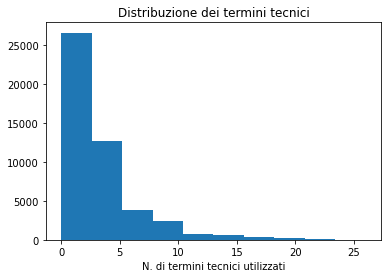

In [ ]:
# Number of expert terms per review

plt.hist(df.expert_terms)#, bins=[0, 1, 4, 8, 30])

plt.title('Technical terms distributions')
plt.xlabel('N. of technical terms used')

In [ ]:
white = pd.read_csv(path + 'white_wines_url_clean.csv', sep=';', encoding='ansi', quotechar='"', header=0)
red = pd.read_csv(path + 'red_wines_clean.csv', sep=';', encoding='ansi', quotechar='"', header=0)
df_wines = pd.concat([white, red])

In [ ]:
df_prices = df.merge(df_wines, how='left', on='url')

In [ ]:
experts_prices = df_prices[df_prices.expert_terms>=expert_threshold].dropna()

amateurs_prices = df_prices[df_prices.expert_terms<expert_threshold].dropna()

In [ ]:
print(np.mean(experts_prices.price))
print(np.mean(amateurs_prices.price))


22.515390283842752
24.805452482402288


Text(0.5, 0, 'prezzo medio speso da utente esperto')

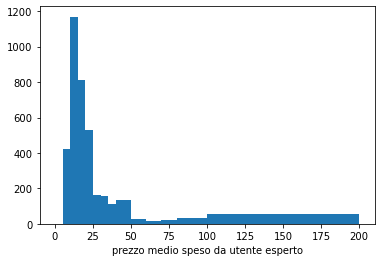

In [ ]:
plt.hist(experts_prices.price, bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100, 200])
plt.xlabel('Average price spent by expert consumer') 

Text(0.5, 0, 'prezzo medio speso da utente non esperto')

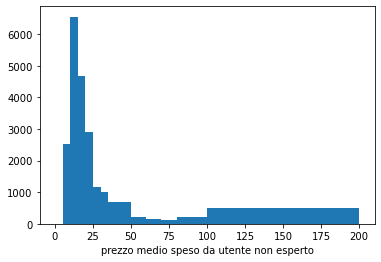

In [ ]:
plt.hist(amateurs_prices.price, bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100, 200])
plt.xlabel('Average price spent by non-expert consumer') 

In [ ]:
cost = [5, 10, 15, 20, 30, 50, 100, 200, 500, 1000, 3000] 
amateurs_prices['price_range'] = ''
price_order = []
for i in range(len(cost)-1):
    amateurs_prices['price_range'] += np.where(np.logical_and(cost[i]<= amateurs_prices.price, amateurs_prices.price < cost[i+1]), str(cost[i])+'-'+str(cost[i+1]), '')
    price_order.append(str(cost[i])+'-'+str(cost[i+1]))
df_grp = amateurs_prices.groupby(['price_range'], as_index=False).count()
df_grp.url = df_grp.url/len(amateurs_prices)


am = alt.Chart(df_grp).mark_area(color = '#8C8C8C', opacity=.5, line = {'color':'#8C8C8C'}).encode(
    y=alt.Y('url:Q', title='Frequency'),
    x=alt.X('price_range:N', title='Price Range (€)', sort=price_order),
    
    #tooltip= [alt.Tooltip('rw', title='Type'), alt.Tooltip('name', title='N. Wines')]
).properties(width=600, height=400)

cost = [5, 10, 15, 20, 30, 50, 100, 200, 500, 1000, 3000] 
experts_prices['price_range'] = ''
price_order = []
for i in range(len(cost)-1):
    experts_prices['price_range'] += np.where(np.logical_and(cost[i]<= experts_prices.price, experts_prices.price < cost[i+1]), str(cost[i])+'-'+str(cost[i+1]), '')
    price_order.append(str(cost[i])+'-'+str(cost[i+1]))
df_grp = experts_prices.groupby(['price_range'], as_index=False).count()
df_grp.url = df_grp.url/len(experts_prices)


exp = alt.Chart(df_grp).mark_area(color = '#BA1628', opacity=.5, line = {'color':'#BA1628'}).encode(
    y=alt.Y('url:Q', title='Frequency'),
    x=alt.X('price_range:N', title='Price Range (€)', sort=price_order),
    
    #tooltip= [alt.Tooltip('rw', title='Type'), alt.Tooltip('name', title='N. Wines')]
).properties(width=600, height=400)

exp + am

alt.LayerChart(...)

In [ ]:
df_grp

,price_range,url,rate,likes,comments,year_x,lang,text,reviewer,date,...,price,food_advice,country,region,wine_type,year_y,legg_strutt,secco_dolce,piatto_acid,notes
0,10-15,0.319050,1169,1169,1169,1169,1169,1169,1169,1169,...,1169,1169,1169,1169,1169,1169,1169,1169,1169,1169
1,100-200,0.015284,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
2,15-20,0.221616,812,812,812,812,812,812,812,812,...,812,812,812,812,812,812,812,812,812,812
3,20-30,0.189138,693,693,693,693,693,693,693,693,...,693,693,693,693,693,693,693,693,693,693
4,200-500,0.004640,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
5,30-50,0.109716,402,402,402,402,402,402,402,402,...,402,402,402,402,402,402,402,402,402,402
6,5-10,0.114902,421,421,421,421,421,421,421,421,...,421,421,421,421,421,421,421,421,421,421
7,50-100,0.025655,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94


Text(0, 0.5, "n. medio di termini tecnici utilizzati dall'utente")

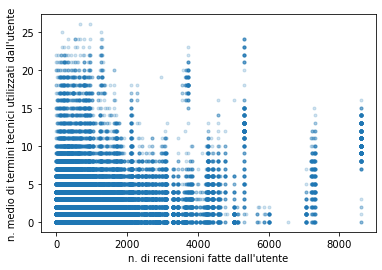

In [ ]:
plt.plot(df.n_reviews, df.expert_terms, '.', alpha=.2)
plt.xlabel('N. of reviews made by consumer')
plt.ylabel('Average number of technical terms used by consumer')


(array([14973.,  9428.,  6576.,  4662.,  3067.,  2928.,  3135.,  2465.,
          410.,    33.]),
 array([21. , 28.8, 36.6, 44.4, 52.2, 60. , 67.8, 75.6, 83.4, 91.2, 99. ]),
 <BarContainer object of 10 artists>)

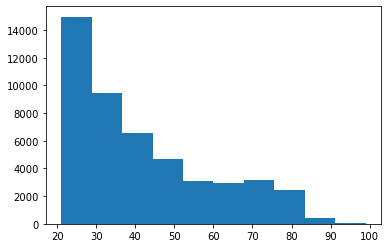

In [ ]:
plt.hist(df['len_review'])
#50% of short reviews not to consider


Text(0, 0.5, "n. medio di termini tecnici utilizzati dall'utente")

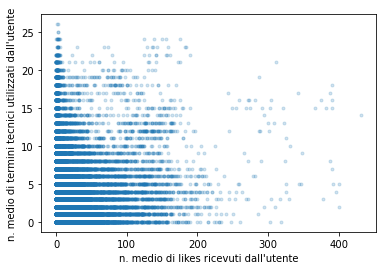

In [ ]:

plt.plot(df.likes, df.expert_terms, '.', alpha=.2)

plt.xlabel('N. of reviews made by consumer')
plt.ylabel('Average number of technical terms used by consumer')


Text(0, 0.5, "n. medio di termini tecnici utilizzati dall'utente")

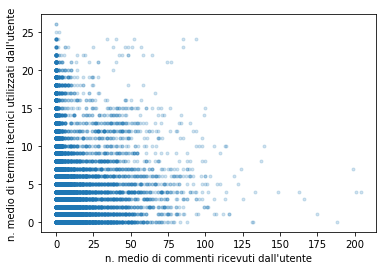

In [ ]:
# The more you are an expert, the less comments you receive

plt.plot(df.comments, df.termini_esperti, '.', alpha=.2)


plt.xlabel('Average number of comments received by a user')
plt.ylabel('Average number of technical terms used by consumer')
